# Texture Features
[Image texture](https://en.wikipedia.org/wiki/Image_texture)<br>
[Co-occurrence matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix)<br>
[GLCM Texture: A Tutorial](https://prism.ucalgary.ca/handle/1880/51900)<br>
[Haralick Features (p619)](http://haralick.org/journals/TexturalFeatures.pdf)<br>
[3D Gray Level Co-Occurrence Matrix Based Classification](https://file.scirp.org/pdf/JBM_2016031715424547.pdf)<br>
[DMCA
Wavelet-Based Texture Classification of Tissues](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.73.6219)<br>

In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import time
import itertools
from math import sqrt, log, atan, degrees

from skimage import feature
from skimage.transform import resize

import sys
sys.path.append('..')
from util.nifti import *

In [3]:
df = pd.read_csv('../csvs/GT_Training.csv', header=None, names=['file','label'])
df.file = df.file.map(lambda x: x.replace("'",''))
df['img'] = df.file.map(lambda x: nib.load('../data/' + str(x) + '.nii.gz'))

In [4]:
img = df.img[0]
data = img.get_fdata()
data.shape

(89, 140, 50)

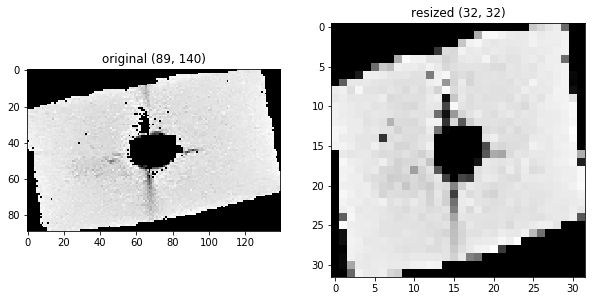

In [5]:
test_layer = data[:,:,25]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,10))

ax1.imshow(test_layer, cmap=plt.cm.gray)
ax1.set_title('original ' + str(test_layer.shape))

resized_layer = resize(test_layer, (32,32), mode='reflect', anti_aliasing=False)

ax2.imshow(resized_layer, cmap=plt.cm.gray)
ax2.set_title('resized ' + str(resized_layer.shape))

plt.show()

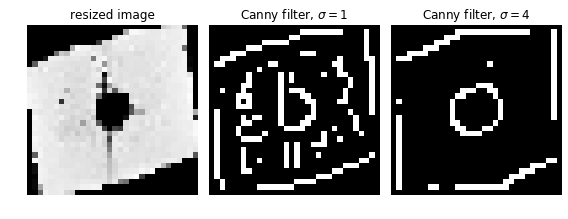

In [6]:
# Compute the Canny filter for two values of sigma
test_layer_resized = resize(test_layer, (32,32), mode='reflect', anti_aliasing=False)
edges1 = feature.canny(test_layer_resized, sigma=1)
edges2 = feature.canny(test_layer_resized, sigma=4)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(test_layer_resized, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('resized image')

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$')

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=4$')

fig.tight_layout()

plt.show()

In [7]:
data32 = resize(data, (32,32,32), mode='reflect', anti_aliasing=False)
edges_array = np.zeros((32,32,32))
sigma = 4
for i in range(data32.shape[2]):
    edges_array[i,:,:] += feature.canny(data32[i,:,:], sigma=sigma)
    edges_array[:,i,:] += feature.canny(data32[:,i,:], sigma=sigma)
    edges_array[:,:,i] += feature.canny(data32[:,:,i], sigma=sigma)
edges_array /= 3

nrows: 4, ncols: 8, nslices: 32


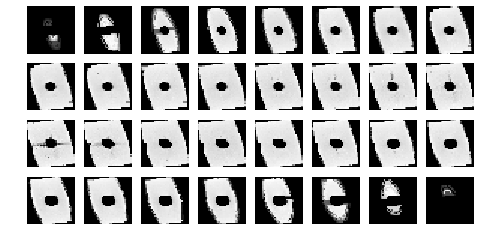

nrows: 4, ncols: 8, nslices: 32


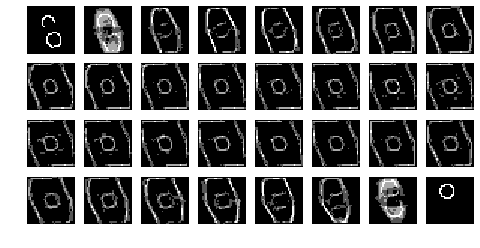

In [8]:
dim = 2
plot_dim(data32, dim=dim)
plot_dim(edges_array, dim=dim)

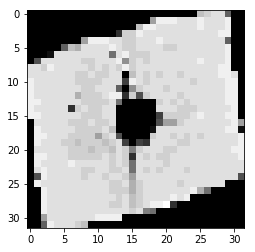

In [9]:
def quantize_image(data, n_levels):
    steps = np.max(data) / n_levels
    return (data / steps).astype(int)
Ng = 16
I = quantize_image(test_layer_resized, Ng)
plt.imshow(I,cmap=plt.cm.gray);plt.show()

In [10]:
def compute_glcm(I, Ng, dx, dy, dz, symmetric=True):
    '''gray level co-occurence matrix
    I: quantized image
    Ng: number of gray levels in quantized image
    https://en.wikipedia.org/wiki/Co-occurrence_matrix'''
    glcm = np.zeros((Ng,Ng))
    ix = itertools.product(range(Ng), range(Ng),
                           range(I.shape[0]), range(I.shape[1]), range(I.shape[2]))
    for i, j, x, y, z in ix:
        try:
            if I[x,y,z] == i and I[x+dx, y+dy, z+dz] == j:
                glcm[i,j] += 1
        except:
            pass
    if symmetric:
        glcm += glcm.T
    return glcm / np.sum(glcm)

def compute_glcv(glcm, Ng):
    '''gray level co-occurence vector
    https://prism.ucalgary.ca/handle/1880/51900 page 24'''
    glcv = np.zeros((Ng))
    for i, j in itertools.product(range(Ng), range(Ng)):
        glcv[abs(i-j)] += glcm[i,j]
    return glcv

def compute_contrast(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 30'''
    contrast = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        contrast += (i-j)**2 * glcm[i,j]
    return contrast

def compute_dissimilarity(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 32'''
    dissimilarity = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        dissimilarity += abs(i-j) * glcm[i,j]
    return dissimilarity

def compute_homogeneity(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 32'''
    homogeneity = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        homogeneity += glcm[i,j] / (1 + (i-j)**2)
    return homogeneity
        
def compute_angular_2nd_moment(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 36'''
    a2m = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        a2m += glcm[i,j]**2
    return a2m

def compute_energy(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 36'''
    return sqrt(compute_angular_2nd_moment)

def compute_entropy(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 37'''
    entropy = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        if glcm[i,j] != 0:
            entropy += glcm[i,j] * -log(glcm[i,j])
    return entropy

def compute_glcm_mean(glcm, Ng, axis):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 40'''
    mean = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        if axis == 0:
            mean += i * glcm[i,j]
        elif axis == 1:
            mean += j * glcm[i,j]
    return mean

def compute_glcm_variance(glcm, Ng, axis, mean=None):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 41'''
    if mean == None:
        mean = compute_glcm_mean(glcm, Ng, axis)
        
    variance = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        if axis == 0:
            variance += (i-mean)**2 * glcm[i,j]
        elif axis == 1:
            variance += (j-mean)**2 * glcm[i,j]
    return variance

def compute_glcm_std_dev(glcm, Ng, axis, mean=None):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 41'''
    return sqrt(compute_glcm_variance(glcm, Ng, axis))

def compute_correlation(glcm, Ng, u_i, u_j, var_i, var_j):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 43'''
    correlation = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        correlation += glcm[i,j] * (i - u_i) * (j - u_j) / sqrt(var_i * var_j)
    return correlation

def compute_similarity(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 43'''
    similarity = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        similarity += glcm[i,j] / (1 + abs(i-j))
    return similarity

In [11]:
'''
horizontal_glcm = compute_glcm(quantize_image(data32, Ng), Ng, 1, 0, 0)
horizontal_glcv = compute_glcv(horizontal_glcm, Ng)
angular_2nd_moment = compute_angular_2nd_moment(horizontal_glcm, Ng)
energy = sqrt(angular_2nd_moment)
contrast = compute_contrast(horizontal_glcm, Ng)
dissimilarity = compute_dissimilarity(horizontal_glcm, Ng)
entropy = compute_entropy(horizontal_glcm, Ng)
u_i = compute_glcm_mean(horizontal_glcm, Ng, 0)
u_j = compute_glcm_mean(horizontal_glcm, Ng, 1)
var_i = compute_glcm_variance(horizontal_glcm, Ng, 0, u_i)
var_j = compute_glcm_variance(horizontal_glcm, Ng, 1, u_j)
std_dev_i = compute_glcm_std_dev(horizontal_glcm, Ng, 0, u_i)
std_dev_j = compute_glcm_std_dev(horizontal_glcm, Ng, 1, u_j)
correlation = compute_correlation(horizontal_glcm, Ng, u_i, u_j, var_i, var_j)
similarity = compute_similarity(horizontal_glcm, Ng)
'''

'\nhorizontal_glcm = compute_glcm(quantize_image(data32, Ng), Ng, 1, 0, 0)\nhorizontal_glcv = compute_glcv(horizontal_glcm, Ng)\nangular_2nd_moment = compute_angular_2nd_moment(horizontal_glcm, Ng)\nenergy = sqrt(angular_2nd_moment)\ncontrast = compute_contrast(horizontal_glcm, Ng)\ndissimilarity = compute_dissimilarity(horizontal_glcm, Ng)\nentropy = compute_entropy(horizontal_glcm, Ng)\nu_i = compute_glcm_mean(horizontal_glcm, Ng, 0)\nu_j = compute_glcm_mean(horizontal_glcm, Ng, 1)\nvar_i = compute_glcm_variance(horizontal_glcm, Ng, 0, u_i)\nvar_j = compute_glcm_variance(horizontal_glcm, Ng, 1, u_j)\nstd_dev_i = compute_glcm_std_dev(horizontal_glcm, Ng, 0, u_i)\nstd_dev_j = compute_glcm_std_dev(horizontal_glcm, Ng, 1, u_j)\ncorrelation = compute_correlation(horizontal_glcm, Ng, u_i, u_j, var_i, var_j)\nsimilarity = compute_similarity(horizontal_glcm, Ng)\n'

In [18]:
Ng = 16
displacement_vectors = [[0,1,0],[-1,1,0],[-1,0,0],[-1,-1,0],
                       [0,1,-1],[0,0,-1],[0,-1,-1],[-1,0,-1],
                       [1,0,-1],[-1,1,-1],[1,-1,-1],[-1,-1,-1],[1,1,-1]]

texture_flat = []

start = time.time()
start100 = start
for i, img in enumerate(df.img[:1]):
    if i % 1 == 0 and i != 0:
        now = time.time()
        print('i = {:<10d}time for last 100 = {:<10.3g}total time = {:<10.3g}'.format(i,now-start100,now-start))
        start100 = time.time()
        
    data = img.get_fdata()
    data32 = resize(data, (32,32,32), mode='reflect', anti_aliasing=False)
    quantized_img = quantize_image(data32, Ng)
    
    texture_features = []
    for d in displacement_vectors[:]:
        print(d)
        dx,dy,dz = d
        glcm = compute_glcm(quantized_img, Ng, dx, dy, dz)
        print(d)
        glcv = compute_glcv(glcm, Ng)
        angular_2nd_moment = compute_angular_2nd_moment(glcm, Ng)
        energy = sqrt(angular_2nd_moment)
        contrast = compute_contrast(glcm, Ng)
        dissimilarity = compute_dissimilarity(glcm, Ng)
        entropy = compute_entropy(glcm, Ng)
        mean = compute_glcm_mean(glcm, Ng, 0)
        var = compute_glcm_variance(glcm, Ng, 0, mean)
        std_dev = sqrt(var)
        correlation = compute_correlation(glcm, Ng, mean, mean, var, var)
        similarity = compute_similarity(glcm, Ng)
        features = list(glcv) + [angular_2nd_moment, energy, contrast, dissimilarity,
                               entropy, mean, var, std_dev, correlation, similarity]
        texture_features.append(features)
    texture_features = np.array(texture_features)
    texture_flat.append(list(np.resize(texture_features, np.product(texture_features.shape))))



[0, 1, 0]
[0, 1, 0]
[-1, 1, 0]
[-1, 1, 0]
[-1, 0, 0]
[-1, 0, 0]
[-1, -1, 0]
[-1, -1, 0]
[0, 1, -1]
[0, 1, -1]
[0, 0, -1]
[0, 0, -1]
[0, -1, -1]
[0, -1, -1]
[-1, 0, -1]
[-1, 0, -1]
[1, 0, -1]
[1, 0, -1]
[-1, 1, -1]
[-1, 1, -1]
[1, -1, -1]
[1, -1, -1]
[-1, -1, -1]
[-1, -1, -1]
[1, 1, -1]
[1, 1, -1]


In [17]:
np.array(texture_flat)

array([[7.63310440e-01, 1.20156260e-01, 1.63190725e-02, 1.34837124e-02,
        1.06798563e-02, 8.41156827e-03, 8.41156827e-03, 5.54470418e-03,
        6.30080020e-03, 4.09552013e-03, 3.71747212e-03, 3.71747212e-03,
        3.84348812e-03, 4.47356814e-03, 1.03963203e-02, 1.71381765e-02,
        2.27181115e-01, 4.76635201e-01, 1.00222733e+01, 1.03953752e+00,
        2.35222214e+00, 7.68412513e+00, 4.50046116e+01, 6.70854765e+00,
        8.88652818e-01, 8.41768629e-01, 7.19614391e-01, 1.31056644e-01,
        1.61615525e-02, 1.30741604e-02, 1.12784324e-02, 9.86075232e-03,
        9.70323231e-03, 7.81299225e-03, 8.09652826e-03, 6.20628820e-03,
        5.95425619e-03, 5.35568017e-03, 5.54470418e-03, 8.69510428e-03,
        1.85873606e-02, 2.29979207e-02, 2.08926155e-01, 4.57084407e-01,
        1.48224119e+01, 1.43377859e+00, 2.46931573e+00, 7.68412513e+00,
        4.50046116e+01, 6.70854765e+00, 8.35323410e-01, 8.06292350e-01,
        7.58743820e-01, 1.15363487e-01, 1.43441372e-02, 1.284868